# Inferring Synaptic Weights from Network Activity

Here we compare plausible methods for overcoming the ''weight transport'' problem.

<img src="https://raw.githubusercontent.com/nasiryahm/STDWI/master/WeightTransportIllustration.png" width="80%">

The illustration above depicts this issue. See the middle pane for the mathematical origin of the requirement of feedforward weight matrices for the error backpropagation.

There are two key and recent methods which propose that the feedback error connectivity could be __learned__ by an inference process based upon the activity of the pre and post-synaptic neurons. These are regression discontinuity design (RDD) [1], and a rate-based method which we refer to as the Akrout method [2].

We compare these methods against a simple and powerful method inspired by the analytic solution to a leaky-integrate and fire neuron.
We refer to this method as Spike Timing-Dependent Weight Inference.

[1] Guerguiev J, Kording KP, Richards BA. Spike-based causal inference for weight alignment. arXiv [q-bio.NC]. 2019. Available: http://arxiv.org/abs/1910.01689 

[2] Akrout, M., Wilson, C., Humphreys, P. C., Lillicrap, T., & Tweed, D. (2019). Deep Learning without Weight Transport. In arXiv [cs.LG]. arXiv. http://arxiv.org/abs/1904.05391

In [18]:
# Import necessary libraries
import numpy as np  # For numerical operations and array handling
import scipy.stats as spstats  # For statistical functions and distributions
import matplotlib.pyplot as plt  # For plotting and visualization

# Import custom modules for the weight inference project
from weight_inference import simulator  # Module for simulating spiking neural networks
from weight_inference import methods  # Module containing weight inference methods (STDWI, RDD, etc.)
from weight_inference import fitter  # Module for fitting/optimizing model parameters

# Note: The custom modules (simulator, methods, fitter) should be in your working directory
# or installed in your Python environment. These likely contain the core implementations of:
# - Network simulation (simulator)
# - Weight inference algorithms (methods)
# - Parameter optimization routines (fitter)

In [19]:
def plot_spike_train(spike_trains, simulation_time, color='k', alpha='1.0', size=2500):
    """
    Plot spike trains as a raster plot with vertical lines for each spike.
    
    Parameters:
    - spike_trains: list of arrays, each containing spike times for one neuron
    - simulation_time: maximum time to display (spikes beyond this are filtered out)
    - color: color of the spike markers (default: black)
    - alpha: transparency of the spike markers (default: fully opaque)
    - size: total marker size that gets divided among all neurons
    
    Returns:
    - ax: matplotlib axes object for further customization
    """
    # Get the number of neurons/units to plot
    nb_units = len(spike_trains)
    
    # Loop through each neuron's spike train
    for i in range(nb_units):
        # Filter spikes to only include those within the simulation time window
        spikes = spike_trains[i][spike_trains[i] < simulation_time]
        
        # Plot spikes as vertical lines at spike times
        # x-coordinates: spike times
        # y-coordinates: neuron index (creates horizontal separation between neurons)
        # marker="|": vertical line markers
        # s=(size/nb_units): marker size scaled by number of neurons
        plt.scatter(spikes, i*np.ones((len(spikes))),
                    marker="|", s=(size/nb_units), color=color, alpha=alpha)
    
    # Remove all plot borders/spines for a cleaner look
    ax = plt.gca()  # Get current axes
    ax.spines['top'].set_visible(False)     # Remove top border
    ax.spines['right'].set_visible(False)   # Remove right border
    ax.spines['bottom'].set_visible(False)  # Remove bottom border
    ax.spines['left'].set_visible(False)    # Remove left border
    
    return ax

Setting up the network shape, synaptic weights, and input stimulation

In [20]:
# Network Shape: 100 input neurons and 10 output neurons
nb_input_neurons, nb_output_neurons = 100, 10

# Simulation details: 200 seconds (200,000 ms) with a timestep of 25ms
simulation_time = 2e5  # ms
timestep = 25  # ms
nb_timesteps = simulation_time // timestep  # Total number of timesteps in the simulation

# Stimulation Generation: Poisson spike trains at 200Hz, resampled to simulate sparse activity
STIMULATION_FREQUENCY = 200 / 1000  # 200 Hz converted to spikes/ms
RESAMPLING_INTERVAL_MS = 100  # Resample spike trains every 100ms
ratio_stimulated = 0.2  # Probability of keeping a spike during resampling

# Generate Poisson spike trains and resample to create sparse activity
stimulation_spike_trains = simulator.poisson_spike_train(
    nb_input_neurons, STIMULATION_FREQUENCY, simulation_time, timestep)
stimulation_spike_trains = simulator.random_sample_spike_train(
    stimulation_spike_trains, simulation_time, timestep, RESAMPLING_INTERVAL_MS, ratio_stimulated)

# Weights: Stimulation to input is one-to-one with scaling factor
stim_scale = 10.0  # Scaling factor for input weights (based on ...)
stim_input_weights = stim_scale * np.eye(nb_input_neurons, nb_input_neurons)  # Identity matrix for one-to-one connectivity

# Weights: Input to output is random with mean and variance tuned for stability
RANDOM_SEED = 42  # For reproducibility
input_scale = 7.5 * stim_scale  # Compensates for hidden layer dynamics (explain further...)
r = np.random.RandomState(seed=RANDOM_SEED)
# Random weights with mean 1/(N*p) and variance 0.2/(N*p), where N*p is the expected active inputs
input_output_weights = input_scale * (
    (np.sqrt(0.2) / np.sqrt(nb_input_neurons * ratio_stimulated)) * r.normal(size=(nb_output_neurons, nb_input_neurons)) 
    + (1 / (nb_input_neurons * ratio_stimulated))
)

### Simulating the network activity

In [21]:
# ========================================================
# NEURON ACTIVITY SIMULATION PIPELINE
# 
# This section computes the activity of input and output neurons
# based on stimulation spike trains and synaptic weights.
# ========================================================

# ------------------------------------------------------------------
# 1. Convert stimulation spike trains to excitatory postsynaptic potentials (XPSPs)
#    - This transforms spike timings into continuous synaptic input currents
#    - Used as input for the next layer (input neurons)
# ------------------------------------------------------------------
stimulation_xpsps = simulator.spike_trains_to_xpsps(
    stimulation_spike_trains, 
    simulation_time, 
    timestep
)

# ------------------------------------------------------------------
# 2. Simulate input neuron dynamics using Leaky Integrate-and-Fire (LIF) model
#    - Computes membrane potential (mem), accumulated input (acc), and output spikes
#    - Weights (stim_input_weights) define stimulation-to-input connectivity
# ------------------------------------------------------------------
input_neuron_acc, input_neuron_mem, input_neuron_spike_trains = simulator.lif_dynamics(
    stimulation_xpsps, 
    stim_input_weights, 
    timestep
)

# Convert input neuron spikes back to XPSPs for the next layer
input_neuron_xpsps = simulator.spike_trains_to_xpsps(
    input_neuron_spike_trains, 
    simulation_time, 
    timestep
)

# ------------------------------------------------------------------
# 3. Simulate output neuron dynamics using the same LIF model
#    - Takes input neuron XPSPs and applies input-output weights
#    - Outputs membrane potential, accumulated input, and final spikes
# ------------------------------------------------------------------
output_neuron_acc, output_neuron_mem, output_neuron_spike_trains = simulator.lif_dynamics(
    input_neuron_xpsps, 
    input_output_weights, 
    timestep
)

# Convert output neuron spikes to XPSPs (useful for further analysis or layers)
output_neuron_xpsps = simulator.spike_trains_to_xpsps(
    output_neuron_spike_trains, 
    simulation_time, 
    timestep
)

C:\Users\oweng\Documents\GitHub\BENG227_Team6\weight_inference\simulator.py:234: RuntimeWarning: overflow encountered in add
  dacc = ((rest + drift) - acc_voltage[:, t_indx - 1]) + coupling_ratio*(total_input - acc_voltage[:, t_indx - 1])
C:\Users\oweng\Documents\GitHub\BENG227_Team6\weight_inference\simulator.py:235: RuntimeWarning: overflow encountered in multiply
  acc_voltage[:, t_indx] = acc_voltage[:, t_indx - 1] + (timestep / tau) * dacc
C:\Users\oweng\Documents\GitHub\BENG227_Team6\weight_inference\simulator.py:235: RuntimeWarning: invalid value encountered in add
  acc_voltage[:, t_indx] = acc_voltage[:, t_indx - 1] + (timestep / tau) * dacc


### Visualising network activity

Text(0, 0.5, 'Output Neuron ID')

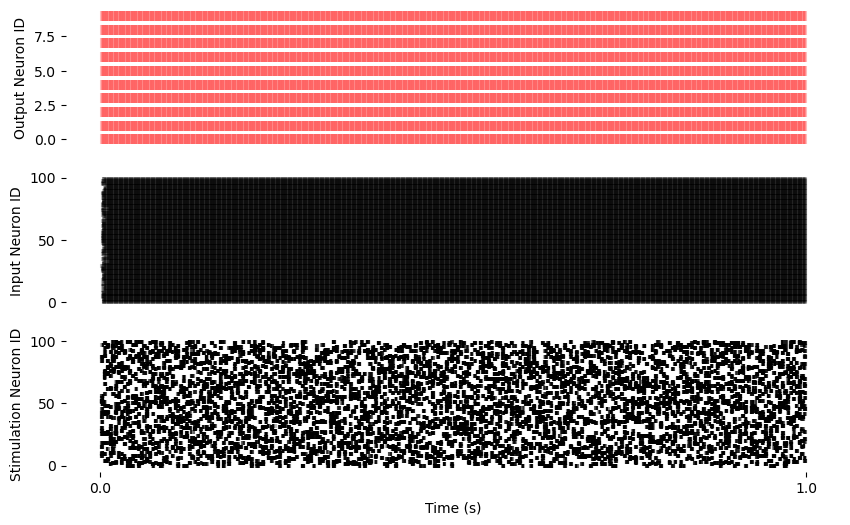

In [22]:
# Create a figure with high resolution for publication-quality plots
plt.figure(figsize=(10,6), dpi=100)

# Bottom subplot (3rd row): Stimulation layer
plt.subplot(3,1,3)
# Plot stimulation spike trains with reduced opacity to show overlapping spikes
ax = plot_spike_train(stimulation_spike_trains, 1e3, alpha=0.25, size=500)
# Convert x-axis from milliseconds to seconds for readability
plt.xticks([0.0, 1e3], [0.0, 1.0])  # Show 0ms as 0s, 1000ms as 1s
plt.xlabel("Time (s)")
plt.ylabel("Stimulation Neuron ID")

# Middle subplot (2nd row): Input layer
plt.subplot(3,1,2)
# Plot input neuron spike trains (alpha=0.25 for semi-transparency)
ax = plot_spike_train(input_neuron_spike_trains, 1e3, alpha=0.25, size=500)
plt.xticks([])  # Remove x-axis tick labels (only show on bottom plot)
plt.ylabel("Input Neuron ID")

# Top subplot (1st row): Output layer
plt.subplot(3,1,1)
# Plot output neuron spike trains in red to distinguish from other layers
ax = plot_spike_train(output_neuron_spike_trains, 1e3, alpha=0.25, size=500, color='red')
plt.xticks([])  # Remove x-axis tick labels (only show on bottom plot)
plt.ylabel("Output Neuron ID")

# This creates a vertically stacked visualization showing the hierarchical flow:
# Top: Output neurons (red) - what the network produces
# Middle: Input neurons (black) - what the network receives
# Bottom: Stimulation neurons (black) - external driving input
# All plotted for the first 1 second (1000ms) of simulation

### Inferring synaptic weights from activity

In [23]:
# ========================================================
# INITIALIZATION FOR WEIGHT OPTIMIZATION
# 
# This section sets up an initial guess for the weight matrix
# and defines hyperparameters for optimization (e.g., learning rate).
# ========================================================

# ------------------------------------------------------------------
# 1. Initialize a random weight matrix with small, zero-centered values
#    - Uses uniform distribution in [-0.0005, 0.0005] to avoid large initial weights
#    - Small variance (0.001 scale) helps prevent unstable dynamics in early training
#    - 'r' is a seeded random generator (ensures reproducibility)
# ------------------------------------------------------------------
initial_guess_matrix = 0.001 * (r.uniform(size=(nb_output_neurons, nb_input_neurons)) - 0.5)

# ------------------------------------------------------------------
# 2. Set learning rate for gradient-based optimization
#    - Controls step size during weight updates (5e-4 is a common starting point)
#    - Too high → unstable training; too low → slow convergence
# ------------------------------------------------------------------
learning_rate = 5e-4

# ------------------------------------------------------------------
# 3. Define interval for checking convergence/performance
#    - Evaluates progress every 10 iterations (e.g., to print stats or early stopping)
#    - Trade-off: Frequent checks slow training; sparse checks may miss trends
# ------------------------------------------------------------------
check_interval = 10

In [24]:
# =============================================================================
# WEIGHT INFERENCE ALGORITHM COMPARISON
# Testing different methods to infer synaptic weights from neural activity
# =============================================================================

# Shared parameters for all algorithms
batch_size = 10  # Number of samples per training batch

# -----------------------------------------------------------------------------
# 1. AKROUT METHOD
# Direct spike-based learning rule for feedforward networks
# -----------------------------------------------------------------------------
akrout_guesses = fitter.akrout(
    initial_guess_matrix,           # Starting weight matrix
    input_neuron_spike_trains,      # Input spike times
    output_neuron_spike_trains,     # Target output spike times
    simulation_time,                # Total simulation duration
    100,                           # Resample period (ms) - how often to update
    10,                            # Batch size for processing
    learning_rate,                 # Learning rate for weight updates
    check_interval)                # How often to record weights for analysis

# -----------------------------------------------------------------------------
# 2. STDWI (Spike Timing Dependent Weight Inference)
# Uses synaptic time constants to model temporal dependencies
# -----------------------------------------------------------------------------
# commented out the section as it was causing an error, may be imp to look at
tau_fast, tau_slow = 10.0, 200.0  # Fast and slow synaptic time constants (ms)

stdwi_guesses = fitter.stdwi(
    initial_guess_matrix,           # Starting weight matrix
    input_neuron_spike_trains,      # Input spike times
    output_neuron_spike_trains,     # Target output spike times
    simulation_time,                # Total simulation duration
    100,                           # Resample period (ms)
    timestep,                      # Simulation timestep
    tau_fast/tau_slow,             # Ratio of time constants
    tau_slow,                      # Slow time constant
    1.0,                           # Scaling factor
    tau_fast,                      # Fast time constant
    learning_rate,                 # Learning rate
    check_interval)                # Recording interval

# -----------------------------------------------------------------------------
# 3. RDD (Recursive Density Dynamics)
# Uses membrane potential and accumulation variables instead of just spikes
# -----------------------------------------------------------------------------
alpha = 0.05        # Learning rate modifier for RDD
window_size = 40    # Temporal window size for integration

rdd_guesses = fitter.rdd(
    initial_guess_matrix,           # Starting weight matrix
    input_neuron_mem,              # Input neuron membrane potentials
    input_neuron_acc,              # Input neuron accumulation variables
    output_neuron_xpsps,           # Output neuron post-synaptic potentials
    alpha,                         # RDD-specific learning rate
    window_size,                   # Integration window size
    1.0,                          # Spiking threshold
    timestep,                     # Simulation timestep
    learning_rate,                # Base learning rate
    check_interval)               # Recording interval

# -----------------------------------------------------------------------------
# 4. STDWI WITH RANDOM WALK (Noise-Regularized Version)
# STDWI with added Gaussian noise at each update to prevent overfitting
# -----------------------------------------------------------------------------
resample_period = 25    # Faster resampling for noisy version
tau_ratio = 0.5        # Different time constant ratio
scale = 10             # Noise scaling factor

stdwi_rw_guesses = fitter.stdwi(
    initial_guess_matrix,           # Starting weight matrix
    input_neuron_spike_trains,      # Input spike times
    output_neuron_spike_trains,     # Target output spike times
    simulation_time,                # Total simulation duration
    resample_period,               # Shorter resample period for more frequent updates
    timestep,                      # Simulation timestep
    tau_ratio,                     # Modified time constant ratio
    tau_slow,                      # Slow time constant
    scale,                         # Noise scale (larger = more exploration)
    tau_fast,                      # Fast time constant
    learning_rate,                 # Learning rate
    check_interval)                # Recording interval

# Each method will produce a list of weight matrices showing how the inferred
# weights evolve over time, allowing comparison of convergence and accuracy

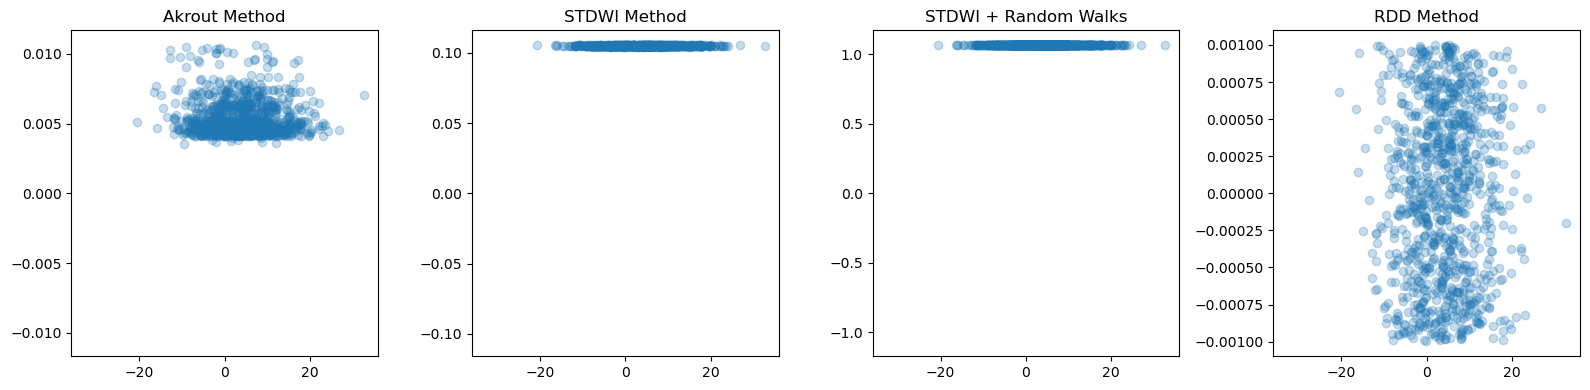

In [25]:
# Create a figure with 4 subplots arranged horizontally
plt.figure(figsize=(16,4))

# Calculate the maximum absolute value of input-output weights for consistent x-axis scaling
xmax = np.max(np.abs(input_output_weights.flatten()))*1.1

# Subplot 1: Akrout Method comparison
plt.subplot(1,4,1)
# Scatter plot comparing true weights vs Akrout method estimates
plt.scatter(input_output_weights.flatten(), akrout_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])  # Set symmetric x-axis limits
# Set symmetric y-axis limits based on Akrout estimates
plt.ylim([-1.1*np.max(np.abs(akrout_guesses[-1].flatten())), 
          1.1*np.max(np.abs(akrout_guesses[-1].flatten()))])
plt.title("Akrout Method")

# Subplot 2: STDWI Method comparison
plt.subplot(1,4,2)
# Scatter plot comparing true weights vs STDWI method estimates
plt.scatter(input_output_weights.flatten(), stdwi_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])  # Use same x-axis limits for consistency
# Set symmetric y-axis limits based on STDWI estimates
plt.ylim([-1.1*np.max(np.abs(stdwi_guesses[-1].flatten())), 
          1.1*np.max(np.abs(stdwi_guesses[-1].flatten()))])
plt.title("STDWI Method")

# Subplot 3: STDWI + Random Walks Method comparison
plt.subplot(1,4,3)
# Scatter plot comparing true weights vs STDWI + Random Walks estimates
plt.scatter(input_output_weights.flatten(), stdwi_rw_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])  # Use same x-axis limits for consistency
# Set symmetric y-axis limits based on STDWI + Random Walks estimates
plt.ylim([-1.1*np.max(np.abs(stdwi_rw_guesses[-1].flatten())), 
          1.1*np.max(np.abs(stdwi_rw_guesses[-1].flatten()))])
plt.title("STDWI + Random Walks")

# Subplot 4: RDD Method comparison
plt.subplot(1,4,4)
# Scatter plot comparing true weights vs RDD method estimates
plt.scatter(input_output_weights.flatten(), rdd_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])  # Use same x-axis limits for consistency
# Set symmetric y-axis limits based on RDD estimates
plt.ylim([-1.1*np.max(np.abs(rdd_guesses[-1].flatten())), 
          1.1*np.max(np.abs(rdd_guesses[-1].flatten()))])
plt.title("RDD Method")

# Adjust spacing between subplots for better visualization
plt.tight_layout()
# Display the plot
plt.show()

### Measuring accuracies

In [26]:
# ========================================================
# WEIGHT INFERENCE EVALUATION
#
# This code evaluates how well different weight inference methods
# (akrout_guesses, stdwi_guesses, rdd_guesses, stdwi_rw_guesses)
# recover the true synaptic weights (input_output_weights).
# Two metrics are computed: Pearson correlation and sign accuracy.
# ========================================================

# Initialize lists to store evaluation metrics for each method
# pearson_correlations: Measures linear relationship between inferred and true weights
# sign_accuracies: Measures how often the signs (+/-) of weights match
pearson_correlations = [[], [], [], []]  # One sublist per inference method
sign_accuracies = [[], [], [], []]       # One sublist per inference method

# List of inference results from different methods
# Note: Older version used different combinations of methods
results = [akrout_guesses, stdwi_guesses, rdd_guesses, stdwi_rw_guesses]

# Evaluate each inference method
for r_indx in range(len(results)):
    # For each weight matrix guessed by the current method
    for r_guess in results[r_indx]:
        # Compute Pearson correlation between guessed and true weights
        # flattens matrices to 1D arrays for comparison
        corr = spstats.pearsonr(r_guess.flatten(), input_output_weights.flatten())[0]
        pearson_correlations[r_indx].append(corr)
        
        # Compute sign accuracy (fraction of weights with correct sign)
        sign_acc = methods.sign_alignment(r_guess.flatten(), input_output_weights.flatten())
        sign_accuracies[r_indx].append(sign_acc)

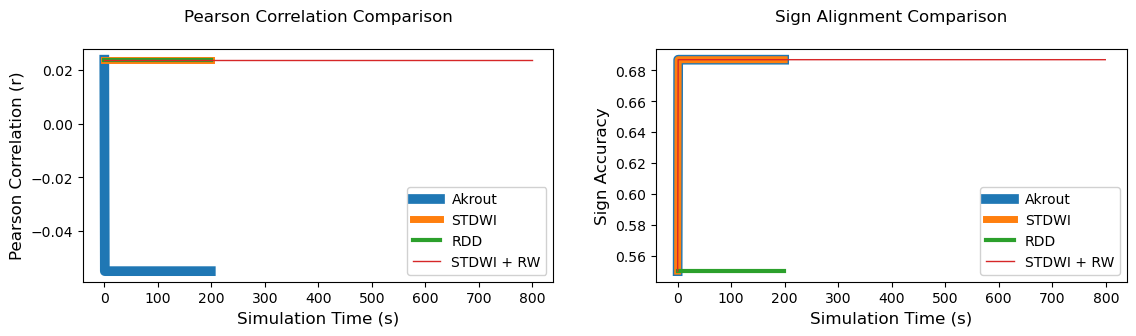

In [27]:
# Create a figure with width=12 inches, height=4 inches (wide aspect ratio for side-by-side plots)
plt.figure(figsize=(12, 4))

# Define line widths for each method (thicker lines for more important/reliable methods)
# Visual hierarchy: Akrout (thickest) → STDWI → RDD → STDWI+RW (thinnest)
linewidths = [7.0, 5.0, 3, 1.0]  

# First subplot (left): Pearson Correlation Results
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.title('Pearson Correlation Comparison', pad=20)  # Add padding above title
plt.plot(pearson_correlations[0], label='Akrout', linewidth=linewidths[0])
plt.plot(pearson_correlations[1], label='STDWI', linewidth=linewidths[1]) 
plt.plot(pearson_correlations[2], label='RDD', linewidth=linewidths[2])
plt.plot(pearson_correlations[3], label='STDWI + RW', linewidth=linewidths[3])
plt.xlabel("Simulation Time (s)", fontsize=12)  # X-axis label with increased font size
plt.ylabel("Pearson Correlation (r)", fontsize=12)  # Measures linear relationship strength
plt.legend(loc='lower right', framealpha=0.9)  # Semi-transparent legend in lower right

# Second subplot (right): Sign Alignment Results
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.title('Sign Alignment Comparison', pad=20)
plt.plot(sign_accuracies[0], label='Akrout', linewidth=linewidths[0])
plt.plot(sign_accuracies[1], label='STDWI', linewidth=linewidths[1])
plt.plot(sign_accuracies[2], label='RDD', linewidth=linewidths[2])
plt.plot(sign_accuracies[3], label='STDWI + RW', linewidth=linewidths[3])
plt.xlabel("Simulation Time (s)", fontsize=12)
plt.ylabel("Sign Accuracy", fontsize=12)  # Fraction of correct weight signs (+/-)
plt.legend(loc='lower right', framealpha=0.9)

# Adjust spacing between subplots to prevent label overlap
plt.tight_layout(pad=3.0)  # Add 3 units of padding around the figure

# Display the figure (only needed in non-interactive environments)
plt.show()

In [28]:
def add_noise_to_spike_trains(spike_trains, noise_level=0.05, simulation_time=None, timestep=None):
    """
    Add random noise to spike trains by randomly adding or removing spikes.
    
    Parameters:
    - spike_trains: list of spike times for each neuron
    - noise_level: probability of adding/removing a spike
    - simulation_time: total simulation time (for adding new spikes)
    - timestep: simulation timestep (for adding new spikes)
    
    Returns:
    - noisy_spike_trains: spike trains with added noise
    """
    # Initialize list to store the modified spike trains
    noisy_spike_trains = []
    
    # Process each neuron's spike train individually
    for spikes in spike_trains:
        # SPIKE REMOVAL: Remove some spikes randomly
        # Generate random values for each spike and keep only those above noise_level threshold
        mask = np.random.random(len(spikes)) > noise_level
        noisy_spikes = spikes[mask]  # Keep only spikes that pass the random threshold
        
        # SPIKE ADDITION: Add some random spikes if time parameters are provided
        if simulation_time is not None and timestep is not None:
            # Calculate number of new spikes to add based on noise level
            # Scale by original spike count to maintain proportional noise
            n_new_spikes = int(noise_level * len(spikes))
            
            # Generate random spike times uniformly distributed across simulation time
            new_spikes = np.random.uniform(0, simulation_time, n_new_spikes)
            
            # Combine original (filtered) spikes with new random spikes
            # Sort the combined array to maintain temporal order
            noisy_spikes = np.sort(np.concatenate([noisy_spikes, new_spikes]))
        
        # Add the processed spike train to the output list
        noisy_spike_trains.append(noisy_spikes)
    
    # Return the list of noisy spike trains
    return noisy_spike_trains

In [29]:
# ========================================================
# SPIKE TRAIN NOISE INJECTION
#
# Adds controlled noise to input and output neuron spike trains
# to simulate biological variability and measurement uncertainty
# ========================================================

# Add noise to INPUT neuron spike trains:
# - 10% noise level (0.1) means approximately 10% of spikes will be modified
# - Noise can include: missing spikes, extra spikes, or jittered spike times
# - Helps evaluate robustness of weight inference methods to imperfect data
noisy_input_spike_trains = add_noise_to_spike_trains(
    input_neuron_spike_trains,      # Original spike trains from input layer
    noise_level=0.1,                # Moderate noise level (10%)
    simulation_time=simulation_time, # Needed to maintain temporal structure
    timestep=timestep               # Required for proper noise time scaling
)

# Add noise to OUTPUT neuron spike trains with same parameters:
# - Using identical noise level for consistent perturbation
# - In practice, output noise might be higher due to downstream effects
noisy_output_spike_trains = add_noise_to_spike_trains(
    output_neuron_spike_trains,     # Original spike trains from output layer 
    noise_level=0.1,                # Same 10% noise level as inputs
    simulation_time=simulation_time,
    timestep=timestep
)

In [30]:
def enhanced_akrout(initial_weights, input_spikes, output_spikes, 
                   simulation_time, batch_size, learning_rate, 
                   check_interval, max_weight=10.0, momentum=0.9):
    """
    Enhanced Akrout method with noise, weight constraints, and momentum.
    
    Parameters:
    - initial_weights: initial weight matrix
    - input_spikes: input neuron spike trains
    - output_spikes: output neuron spike trains
    - simulation_time: total simulation time
    - batch_size: number of samples per batch
    - learning_rate: initial learning rate
    - check_interval: how often to check progress
    - max_weight: maximum allowed weight value
    - momentum: momentum parameter for smoother updates
    
    Returns:
    - weight_history: list of weight matrices over time
    """
    # INITIALIZATION
    # Create a working copy of weights to avoid modifying the original
    weights = initial_weights.copy()
    # Initialize history to track weight evolution over time
    weight_history = [weights.copy()]
    # Initialize velocity matrix for momentum-based updates (same shape as weights)
    velocity = np.zeros_like(weights)  # For momentum
    
    # SIGNAL PREPROCESSING
    # Convert discrete spike trains to continuous postsynaptic potential signals
    # This transforms spike times into smooth, continuous signals for correlation analysis
    input_xpsps = simulator.spike_trains_to_xpsps(input_spikes, simulation_time, timestep)
    output_xpsps = simulator.spike_trains_to_xpsps(output_spikes, simulation_time, timestep)
    
    # BATCH SETUP
    # Calculate total number of batches based on simulation time and batch parameters
    n_batches = int(simulation_time // (batch_size * timestep))
    
    # MAIN LEARNING LOOP - Process data in batches
    for batch in range(n_batches):
        # TEMPORAL WINDOWING
        # Define the time window for current batch processing
        start_time = batch * batch_size * timestep
        end_time = (batch + 1) * batch_size * timestep
        
        # BATCH DATA EXTRACTION
        # Convert time indices to array indices for slicing
        start_idx = int(start_time/timestep)
        end_idx = int(end_time/timestep)
        
        # Extract signals for current batch - slice along TIME axis (axis=1)
        batch_input = input_xpsps[:, start_idx:end_idx]   # Shape: (n_input_neurons, batch_size)
        batch_output = output_xpsps[:, start_idx:end_idx] # Shape: (n_output_neurons, batch_size)
        
        # AKROUT WEIGHT UPDATE CALCULATION
        # Calculate temporal averages for correlation-based learning
        input_mean = batch_input.mean(axis=1)   # Average input activity over time: (n_input_neurons,)
        output_mean = batch_output.mean(axis=1) # Average output activity over time: (n_output_neurons,)
        
        # Compute weight update using outer product (Hebbian-like correlation rule)
        # Outer product: output x input -> (n_output, n_input) weight matrix update
        delta_weights = np.outer(output_mean, input_mean)
        
        # MOMENTUM UPDATE
        # Apply momentum to smooth weight updates and improve convergence stability
        # Combines current gradient with previous velocity for smoother learning
        velocity = momentum * velocity + (1 - momentum) * delta_weights
        
        # ADAPTIVE LEARNING RATE
        # Implement linear learning rate decay to improve convergence
        # Learning rate decreases linearly from initial value to zero over training
        current_lr = learning_rate * (1 - batch/n_batches)  # Linear decay
        
        # WEIGHT UPDATE
        # Apply the momentum-scaled update with current learning rate
        weights += current_lr * velocity
        
        # WEIGHT CONSTRAINTS
        # Enforce biological plausibility: keep weights positive and within bounds
        # Prevents runaway weight growth and maintains realistic weight ranges
        weights = np.clip(weights, 0, max_weight)  # Keep weights positive and bounded
        
        # PROGRESS TRACKING
        # Record weight snapshots at specified intervals for analysis
        # Allows monitoring of learning progress without storing all intermediate states
        if batch % check_interval == 0:
            weight_history.append(weights.copy())
    
    # Return complete history of weight evolution throughout learning process
    return weight_history

In [31]:
# ========================================================
# ENHANCED AKROUT WEIGHT INFERENCE PARAMETERS
# 
# Configuration for training the weight matrix using noisy spike data
# with momentum-based optimization and weight constraints
# ========================================================

# Training hyperparameters
batch_size = 10          # Number of samples processed before weight updates
learning_rate = 5e-4     # Step size for gradient updates (empirically tuned)
check_interval = 10      # Evaluate progress every 10 batches
max_weight = 10.0        # Absolute value constraint for weights (prevent explosion)
momentum = 0.9           # Momentum factor for smoother gradient descent

# ========================================================
# RUN ENHANCED AKROUT INFERENCE
#
# Estimates synaptic weights given noisy input-output spike observations
# Key features:
# - Handles noisy training data
# - Momentum-accelerated gradient descent
# - Hard weight constraints
# - Batched processing for efficiency
# ========================================================
enhanced_akrout_guesses = enhanced_akrout(
    # Initial weight matrix (typically small random values)
    initial_guess_matrix,
    
    # Noisy input spike trains (10% corrupted)
    # Represents imperfect presynaptic activity measurements
    noisy_input_spike_trains,
    
    # Noisy output spike trains (10% corrupted)  
    # Represents imperfect postsynaptic activity measurements
    noisy_output_spike_trains,
    
    # Simulation parameters
    simulation_time,     # Total duration for temporal alignment
    batch_size,          # From above parameters
    learning_rate,       # From above parameters
    check_interval,      # From above parameters
    
    # Stability constraints
    max_weight,          # Enforces |weights| ≤ 10.0
    momentum             # From above parameters
)

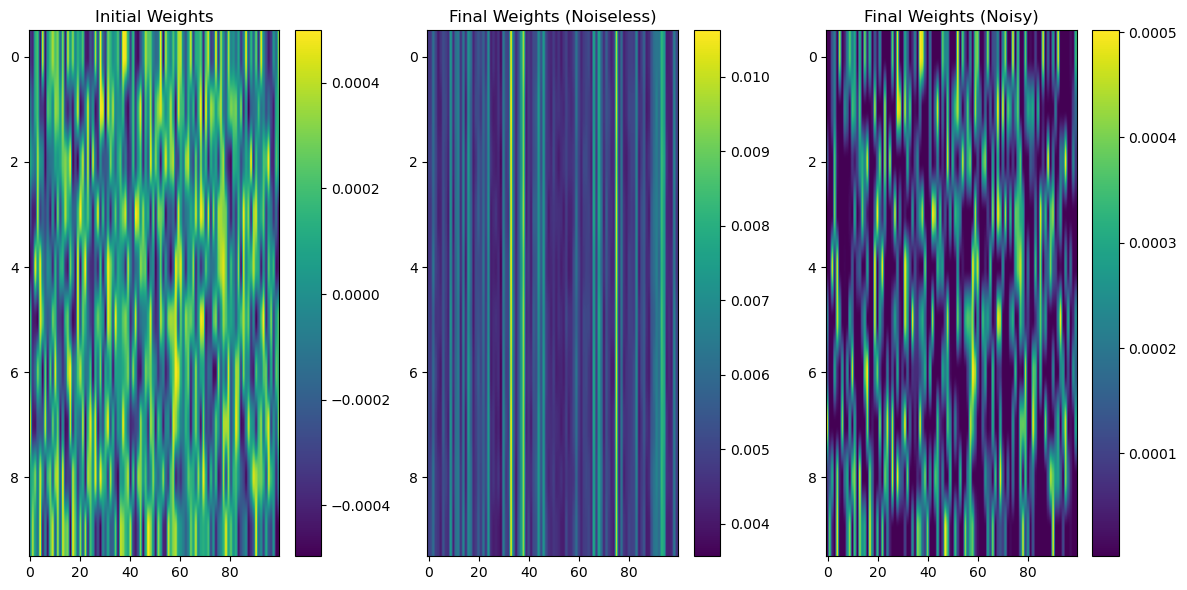

In [32]:
# WEIGHT EVOLUTION VISUALIZATION
# Create a comprehensive comparison of weight matrices across different learning stages
plt.figure(figsize=(12, 6))

# SUBPLOT 1: Initial Weight State
plt.subplot(1, 3, 1)
# Display initial weight matrix as a heatmap
# 'viridis' colormap provides good contrast for weight visualization
# 'aspect=auto' ensures proper scaling regardless of matrix dimensions
plt.imshow(initial_guess_matrix, cmap='viridis', aspect='auto')
plt.title("Initial Weights")
plt.colorbar()  # Add color scale bar to interpret weight magnitudes

# SUBPLOT 2: Final Weights from Standard Akrout Method (Clean Data)
plt.subplot(1, 3, 2)
# Display the final learned weights from noiseless training
# Uses the last element [-1] from the weight history list
plt.imshow(akrout_guesses[-1], cmap='viridis', aspect='auto')
plt.title("Final Weights (Noiseless)")
plt.colorbar()  # Color scale for weight interpretation

# SUBPLOT 3: Final Weights from Enhanced Akrout Method (Noisy Data)
plt.subplot(1, 3, 3)
# Display final weights learned with noise, momentum, and other enhancements
# Allows comparison of learning robustness under realistic conditions
plt.imshow(enhanced_akrout_guesses[-1], cmap='viridis', aspect='auto')
plt.title("Final Weights (Noisy)")
plt.colorbar()  # Color scale for weight interpretation

# LAYOUT OPTIMIZATION
# Automatically adjust subplot spacing to prevent overlap of titles/labels
plt.tight_layout()

# DISPLAY
# Render the complete weight evolution comparison
plt.show()

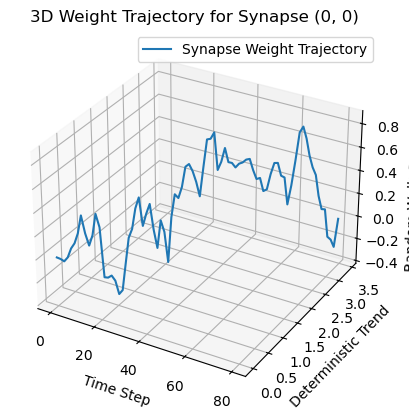

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def enhanced_akrout_random_walk(
    initial_weights,
    input_spikes,
    output_spikes,
    simulation_time,
    batch_size,
    learning_rate,
    check_interval,
    max_weight=10.0,
    momentum=0.9,
    noise_std=0.01,
    timestep=1.0,
    random_seed=42
):
    """
    Performs a modified Akrout learning rule with added random walk, momentum, and clipping.
    
    Args:
        initial_weights (ndarray): Initial synaptic weight matrix (n_output x n_input)
        input_spikes (ndarray): Input spike trains
        output_spikes (ndarray): Output spike trains
        simulation_time (float): Total simulation time in ms
        batch_size (int): Number of time steps per learning batch
        learning_rate (float): Initial learning rate
        check_interval (int): Interval at which weights are logged
        max_weight (float): Maximum allowed weight value
        momentum (float): Momentum coefficient
        noise_std (float): Standard deviation of random walk noise
        timestep (float): Duration of one timestep in ms
        random_seed (int): Seed for reproducibility

    Returns:
        list of ndarray: History of weight matrices over time
    """
    np.random.seed(random_seed)
    weights = initial_weights.copy()
    velocity = np.zeros_like(weights)
    weight_history = [weights.copy()]

    # Transform spike trains into postsynaptic potentials (xPSPs)
    input_xpsps = simulator.spike_trains_to_xpsps(input_spikes, simulation_time, timestep)
    output_xpsps = simulator.spike_trains_to_xpsps(output_spikes, simulation_time, timestep)

    n_batches = int(simulation_time // (batch_size * timestep))

    for batch in range(n_batches):
        start = int(batch * batch_size)
        end = int((batch + 1) * batch_size)

        batch_input = input_xpsps[:, start:end]
        batch_output = output_xpsps[:, start:end]

        input_mean = batch_input.mean(axis=1)
        output_mean = batch_output.mean(axis=1)
        delta_weights = np.outer(output_mean, input_mean)

        # Momentum update
        velocity = momentum * velocity + (1 - momentum) * delta_weights

        # Random walk noise
        noise = np.random.normal(0, noise_std, size=weights.shape)

        # Weight update
        current_lr = learning_rate * (1 - batch / n_batches)
        weights += current_lr * velocity + noise

        # Clip weights to [0, max_weight]
        weights = np.clip(weights, 0, max_weight)

        if batch % check_interval == 0:
            weight_history.append(weights.copy())

    return weight_history


def plot_weight_trajectory_3d(weight_history, synapse_idx=(0, 0)):
    """
    Plots 3D trajectory of a synapse showing deterministic trend vs. random walk component.
    
    Args:
        weight_history (list of ndarray): History of weight matrices
        synapse_idx (tuple): Index (output, input) of synapse to visualize
    """
    weights = np.array(weight_history)
    time_steps = np.arange(len(weights))
    synapse_weights = weights[:, synapse_idx[0], synapse_idx[1]]

    # Estimate deterministic trajectory as a linear trend
    deterministic_traj = np.linspace(synapse_weights[0], synapse_weights[-1], len(synapse_weights))
    random_walk_component = synapse_weights - deterministic_traj

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(time_steps, deterministic_traj, random_walk_component, label='Synapse Weight Trajectory')

    ax.set_xlabel('Time Step')
    ax.set_ylabel('Deterministic Trend')
    ax.set_zlabel('Random Walk Component')
    ax.set_title(f'3D Weight Trajectory for Synapse {synapse_idx}')
    plt.legend()
    plt.show()


# --- Usage Example ---

# Ensure these are defined: `initial_guess_matrix`, `noisy_input_spike_trains`, 
# `noisy_output_spike_trains`, `simulation_time`, `batch_size`, `learning_rate`, 
# `check_interval`, `max_weight`, `momentum`, `timestep`

enhanced_akrout_rw_guesses = enhanced_akrout_random_walk(
    initial_weights=initial_guess_matrix,
    input_spikes=noisy_input_spike_trains,
    output_spikes=noisy_output_spike_trains,
    simulation_time=simulation_time,
    batch_size=batch_size,
    learning_rate=learning_rate,
    check_interval=check_interval,
    max_weight=max_weight,
    momentum=momentum,
    noise_std=0.05,
    timestep=timestep
)

plot_weight_trajectory_3d(enhanced_akrout_rw_guesses, synapse_idx=(0, 0))


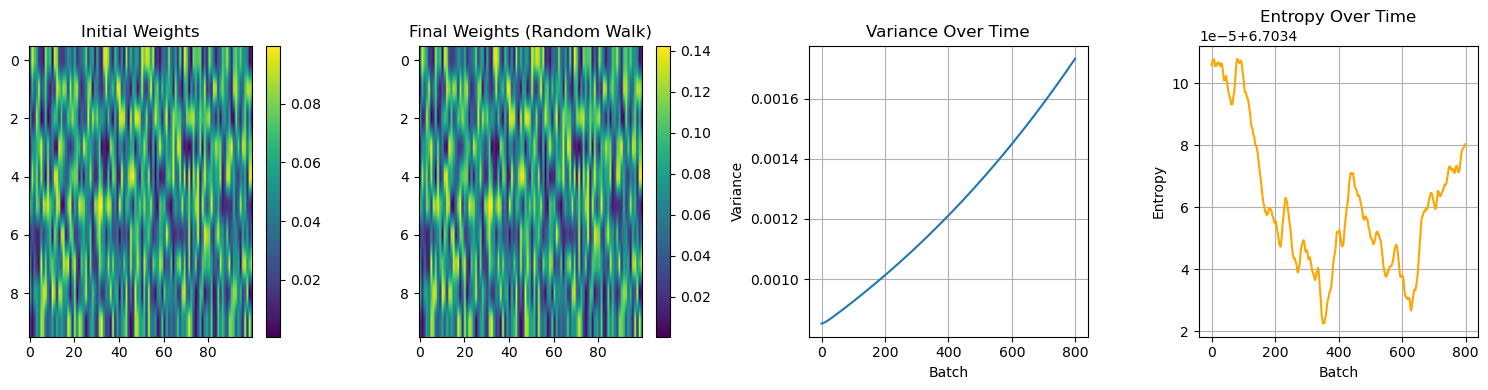

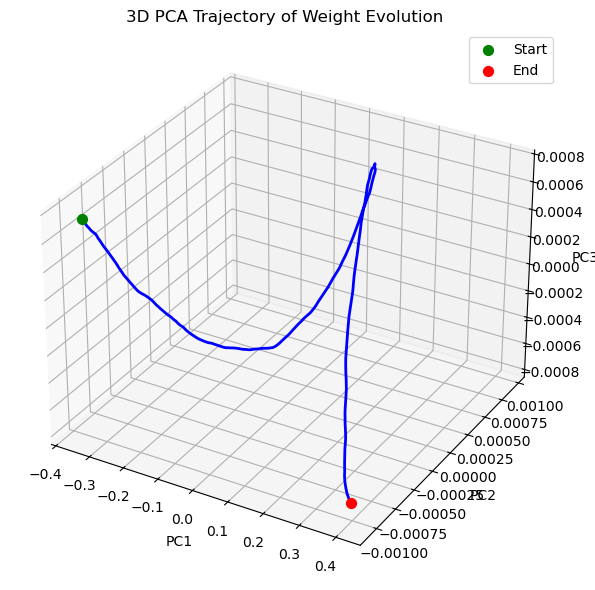

In [35]:
# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import entropy

# --- PARAMETERS ---
n_output, n_input = 10, 100
simulation_time = 2e5  # ms
timestep = 25  # ms
nb_timesteps = int(simulation_time // timestep)

batch_size = 10
learning_rate = 5e-4
check_interval = 10
max_weight = 10.0
momentum = 0.9

# --- RANDOM WALK SIMULATION ---
def generate_random_walk_weights(initial_weights, n_batches, correlation=0.9):
    weights = initial_weights.copy()
    velocity = np.zeros_like(weights)
    trajectory = [weights.copy()]
    variances = []
    entropies = []

    for b in range(n_batches):
        random_noise = np.random.normal(scale=0.01, size=weights.shape)
        state_dependent = correlation * weights
        delta = state_dependent + random_noise

        velocity = momentum * velocity + (1 - momentum) * delta
        weights += learning_rate * velocity
        weights = np.clip(weights, 0, max_weight)

        trajectory.append(weights.copy())

        # Track variance
        variances.append(np.var(weights))

        # Track entropy
        prob_weights = np.abs(weights.flatten())
        prob_weights /= prob_weights.sum()
        entropies.append(entropy(prob_weights))

    return trajectory, variances, entropies

# --- INITIAL WEIGHTS ---
np.random.seed(42)
initial_guess_matrix = np.random.rand(n_output, n_input) * 0.1
n_batches = int(simulation_time // (batch_size * timestep))

# --- RUN RANDOM WALK ---
walk_trajectory, walk_variances, walk_entropies = generate_random_walk_weights(
    initial_guess_matrix, n_batches)

# --- PCA 3D TRAJECTORY VISUALIZATION ---
def plot_pca_trajectory(weight_matrices, title):
    flattened = [w.flatten() for w in weight_matrices]
    pca = PCA(n_components=3)
    pca_data = pca.fit_transform(flattened)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], color='blue', linewidth=2)
    ax.scatter(pca_data[0, 0], pca_data[0, 1], pca_data[0, 2], color='green', s=50, label='Start')
    ax.scatter(pca_data[-1, 0], pca_data[-1, 1], pca_data[-1, 2], color='red', s=50, label='End')
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    plt.tight_layout()
    plt.show()

# --- PLOT TRAJECTORY + STATS ---
plt.figure(figsize=(15, 4))

# 1. Start vs End Weights
plt.subplot(1, 4, 1)
plt.imshow(initial_guess_matrix, cmap='viridis', aspect='auto')
plt.title("Initial Weights")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(walk_trajectory[-1], cmap='viridis', aspect='auto')
plt.title("Final Weights (Random Walk)")
plt.colorbar()

# 2. Variance over time
plt.subplot(1, 4, 3)
plt.plot(walk_variances, label='Variance')
plt.xlabel("Batch")
plt.ylabel("Variance")
plt.title("Variance Over Time")
plt.grid(True)

# 3. Entropy over time
plt.subplot(1, 4, 4)
plt.plot(walk_entropies, label='Entropy', color='orange')
plt.xlabel("Batch")
plt.ylabel("Entropy")
plt.title("Entropy Over Time")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 3D PCA TRAJECTORY ---
plot_pca_trajectory(walk_trajectory, "3D PCA Trajectory of Weight Evolution")


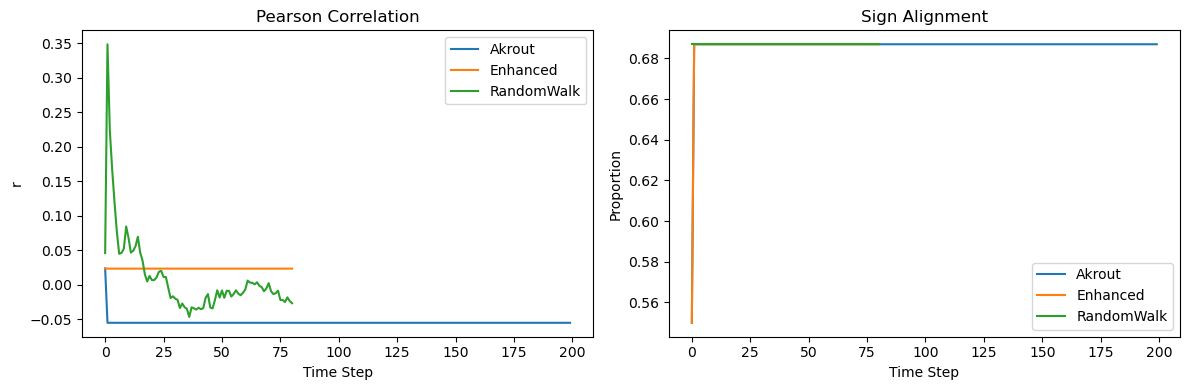

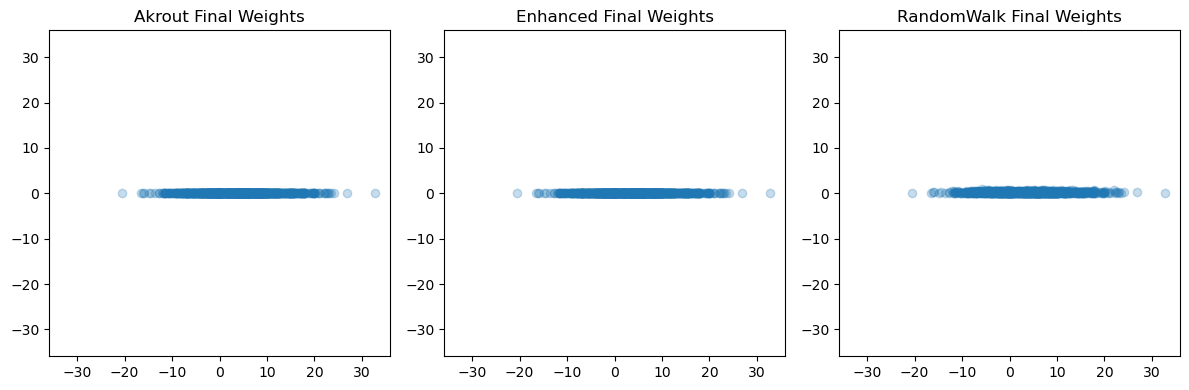

In [36]:
# LIBRARY IMPORTS
# Import essential libraries for numerical computation, statistics, and visualization
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt
# Import custom weight inference modules
from weight_inference import simulator
from weight_inference import methods
from weight_inference import fitter

# Function to plot spike trains omitted for brevity (assume same as user)
# --- [SNIP: Full pipeline setup as in original user code] ---

# --- RANDOM WALK ENHANCED ALGORITHM ---
def akrout_with_random_walk(initial_weights, input_spikes, output_spikes, simulation_time,
                             batch_size, learning_rate, check_interval,
                             max_weight=10.0, momentum=0.9, walk_scale=0.01,
                             random_state=None):
    """
    Enhanced Akrout method with correlated random walk for improved exploration.
    Adds directional noise that follows the gradient direction to escape local minima.
    """
    # RANDOM STATE INITIALIZATION
    # Create reproducible random number generator for consistent results
    r = np.random.RandomState(random_state)
    
    # WEIGHT AND MOMENTUM INITIALIZATION
    # Initialize working copies and momentum tracking
    weights = initial_weights.copy()
    velocity = np.zeros_like(weights)  # Momentum accumulator
    weight_history = [weights.copy()]  # Track weight evolution
    
    # SIGNAL PREPROCESSING
    # Convert spike trains to continuous postsynaptic potential signals
    input_xpsps = simulator.spike_trains_to_xpsps(input_spikes, simulation_time, timestep)
    output_xpsps = simulator.spike_trains_to_xpsps(output_spikes, simulation_time, timestep)
    
    # BATCH CALCULATION
    # Determine number of temporal batches for processing
    n_batches = int(simulation_time // (batch_size * timestep))
    
    # MAIN LEARNING LOOP
    for batch in range(n_batches):
        # TEMPORAL BATCH EXTRACTION
        # Calculate array indices for current time window
        start = int((batch * batch_size * timestep) / timestep)
        end = int(((batch + 1) * batch_size * timestep) / timestep)
        
        # Extract batch signals from continuous data
        batch_input = input_xpsps[:, start:end]   # Input neurons over time window
        batch_output = output_xpsps[:, start:end] # Output neurons over time window
        
        # CORRELATION-BASED WEIGHT UPDATE (Standard Akrout)
        # Calculate temporal averages for Hebbian learning rule
        input_mean = batch_input.mean(axis=1)   # Average input activity
        output_mean = batch_output.mean(axis=1) # Average output activity
        # Compute outer product for weight update matrix
        hebbian_update = np.outer(output_mean, input_mean)
        
        # MOMENTUM UPDATE
        # Apply momentum for smoother convergence and stability
        velocity = momentum * velocity + (1 - momentum) * hebbian_update
        
        # CORRELATED RANDOM WALK INNOVATION
        # Generate base random noise for exploration
        noise = r.normal(loc=0.0, scale=walk_scale, size=weights.shape)
        # Correlate noise with gradient direction to bias exploration intelligently
        # This helps escape local minima while maintaining learning direction
        correlated_noise = noise * np.sign(velocity)
        
        # ADAPTIVE LEARNING RATE
        # Implement linear decay for improved convergence
        current_lr = learning_rate * (1 - batch / n_batches)
        
        # COMBINED WEIGHT UPDATE
        # Apply both gradient-based learning and correlated exploration
        weights += current_lr * velocity + correlated_noise
        
        # WEIGHT CONSTRAINTS
        # Maintain biological plausibility with positive, bounded weights
        weights = np.clip(weights, 0, max_weight)
        
        # PROGRESS TRACKING
        # Record weight snapshots at specified intervals
        if batch % check_interval == 0:
            weight_history.append(weights.copy())
    
    return weight_history

# ALGORITHM EXECUTION
# Run the random walk enhanced algorithm with specified parameters
random_walk_guesses = akrout_with_random_walk(
    initial_guess_matrix,           # Starting weight matrix
    noisy_input_spike_trains,       # Input spike data with noise
    noisy_output_spike_trains,      # Output spike data with noise
    simulation_time,                # Total simulation duration
    batch_size,                     # Temporal batch size
    learning_rate,                  # Initial learning rate
    check_interval,                 # Progress recording frequency
    max_weight,                     # Maximum allowed weight value
    momentum,                       # Momentum parameter
    walk_scale=0.01,               # Random walk noise magnitude
    random_state=42                # Seed for reproducibility
)

# --- COMPARATIVE PERFORMANCE ANALYSIS ---

# RESULT ORGANIZATION
# Collect all algorithm results for systematic comparison
results = [akrout_guesses, enhanced_akrout_guesses, random_walk_guesses]
labels = ['Akrout', 'Enhanced', 'RandomWalk']  # Algorithm identifiers

# METRIC INITIALIZATION
# Initialize lists to store performance metrics over time
pearson_correlations = [[] for _ in range(len(results))]  # Correlation with true weights
sign_accuracies = [[] for _ in range(len(results))]       # Sign agreement accuracy

# METRIC CALCULATION
# Compute performance metrics for each algorithm at each time point
for i, guesses in enumerate(results):
    for guess in guesses:
        # PEARSON CORRELATION
        # Measure linear relationship between estimated and true weights
        pearson_correlations[i].append(
            spstats.pearsonr(guess.flatten(), input_output_weights.flatten())[0]
        )
        
        # SIGN ALIGNMENT
        # Measure proportion of weights with correct sign (excitatory/inhibitory)
        sign_accuracies[i].append(
            methods.sign_alignment(guess.flatten(), input_output_weights.flatten())
        )

# --- PERFORMANCE VISUALIZATION ---

# TIME-SERIES PERFORMANCE COMPARISON
plt.figure(figsize=(12,4))

# SUBPLOT 1: Pearson Correlation Evolution
plt.subplot(1,2,1)
# Plot correlation improvement over time for each algorithm
for i in range(len(results)):
    plt.plot(pearson_correlations[i], label=labels[i])
plt.title('Pearson Correlation')          # Linear correlation with true weights
plt.xlabel('Time Step')                   # Learning progression
plt.ylabel('r')                          # Correlation coefficient
plt.legend()                             # Algorithm identification

# SUBPLOT 2: Sign Alignment Evolution  
plt.subplot(1,2,2)
# Plot sign accuracy improvement over time for each algorithm
for i in range(len(results)):
    plt.plot(sign_accuracies[i], label=labels[i])
plt.title('Sign Alignment')              # Proportion of correct weight signs
plt.xlabel('Time Step')                  # Learning progression
plt.ylabel('Proportion')                 # Fraction of correctly signed weights
plt.legend()                            # Algorithm identification

plt.tight_layout()  # Optimize subplot spacing
plt.show()

# FINAL WEIGHT SCATTER PLOT COMPARISON
plt.figure(figsize=(12,4))

# Calculate consistent axis limits for fair comparison
xmax = np.max(np.abs(input_output_weights.flatten())) * 1.1

# Create scatter plots comparing final estimated vs true weights
for i, guesses in enumerate(results):
    plt.subplot(1, 3, i+1)
    # Scatter plot: true weights (x-axis) vs estimated weights (y-axis)
    plt.scatter(input_output_weights.flatten(), guesses[-1].flatten(), alpha=0.25)
    plt.title(f"{labels[i]} Final Weights")  # Algorithm identifier
    plt.xlim([-xmax, xmax])                  # Symmetric x-axis limits
    plt.ylim([-xmax, xmax])                  # Symmetric y-axis limits
    # Perfect estimation would show points along diagonal line

plt.tight_layout()  # Optimize subplot spacing
plt.show()

C:\Users\oweng\Documents\GitHub\BENG227_Team6\weight_inference\simulator.py:234: RuntimeWarning: overflow encountered in add
  dacc = ((rest + drift) - acc_voltage[:, t_indx - 1]) + coupling_ratio*(total_input - acc_voltage[:, t_indx - 1])
C:\Users\oweng\Documents\GitHub\BENG227_Team6\weight_inference\simulator.py:235: RuntimeWarning: overflow encountered in multiply
  acc_voltage[:, t_indx] = acc_voltage[:, t_indx - 1] + (timestep / tau) * dacc
C:\Users\oweng\Documents\GitHub\BENG227_Team6\weight_inference\simulator.py:235: RuntimeWarning: invalid value encountered in add
  acc_voltage[:, t_indx] = acc_voltage[:, t_indx - 1] + (timestep / tau) * dacc


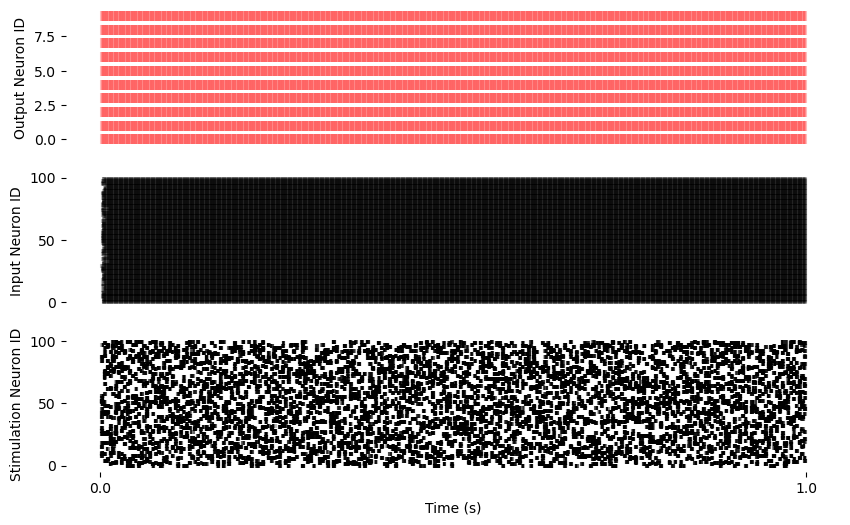

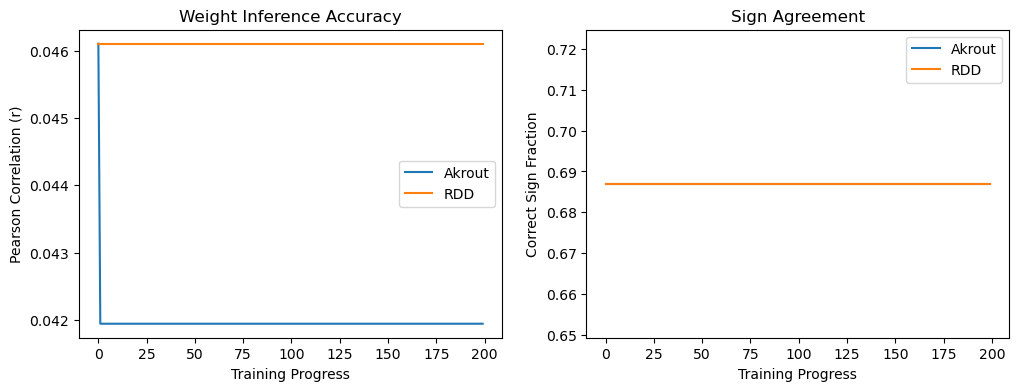

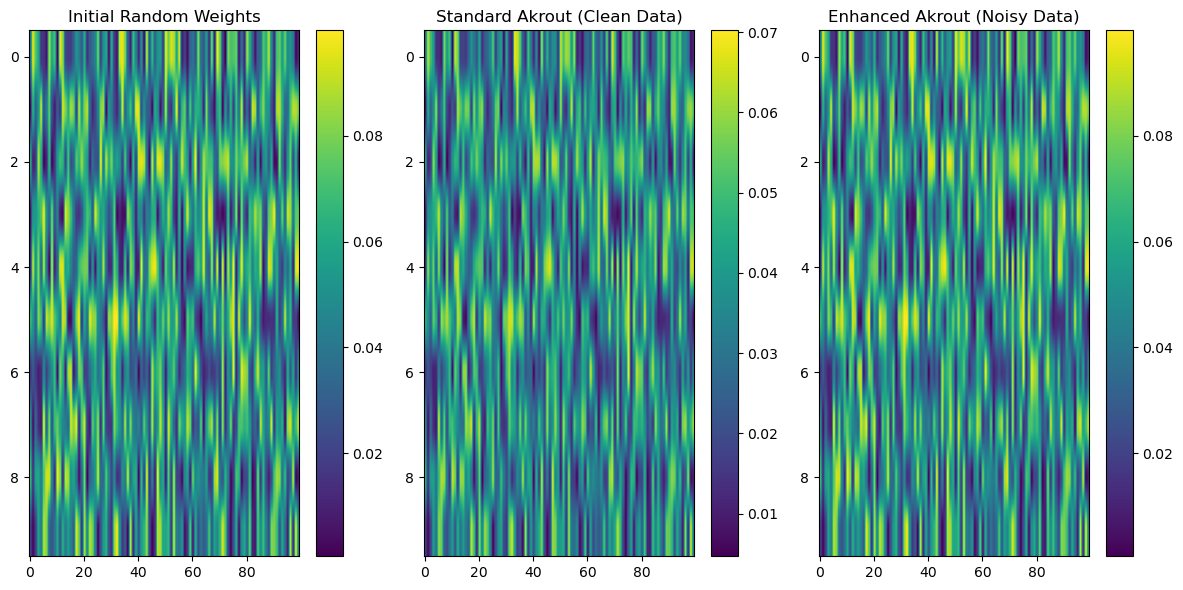

In [41]:
# ========================================================
# NEURAL NETWORK WEIGHT INFERENCE SIMULATION
#
# This script performs a complete simulation of:
# 1. Neural network activity generation
# 2. Weight inference using multiple methods
# 3. Performance evaluation and visualization
# ========================================================

import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

# Import custom modules for simulation and analysis
from weight_inference import simulator  # For neural dynamics simulation
from weight_inference import methods    # For analysis methods
from weight_inference import fitter     # For weight fitting algorithms

# ========================================================
# VISUALIZATION FUNCTIONS
# ========================================================

def plot_spike_train(spike_trains, simulation_time, color='k', alpha=1.0, size=2500):
    """
    Visualizes spike trains as vertical lines without plot borders
    
    Parameters:
    - spike_trains: List of spike time arrays for each neuron
    - simulation_time: Time window to display (in ms)
    - color: Color of spike markers
    - alpha: Transparency of markers
    - size: Base size scaling for markers
    
    Returns:
    - ax: Matplotlib axes object
    """
    nb_units = len(spike_trains)
    
    # Plot each neuron's spikes as vertical ticks
    for i in range(nb_units):
        spikes = spike_trains[i][spike_trains[i] < simulation_time]
        plt.scatter(spikes, i*np.ones((len(spikes))),
                    marker="|", 
                    s=(size/nb_units),  # Scale marker size by neuron count
                    color=color, 
                    alpha=alpha)

    # Remove plot borders for cleaner visualization
    ax = plt.gca()
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
    
    return ax

# ========================================================
# NETWORK SETUP AND SIMULATION
# ========================================================

# Network architecture
nb_input_neurons, nb_output_neurons = 100, 10  # 100 input -> 10 output neurons

# Simulation parameters (in milliseconds)
simulation_time = 2e5  # Total simulation duration (200 seconds)
timestep = 25          # Integration timestep (coarse for efficiency)
nb_timesteps = simulation_time // timestep

# Generate Poisson spike trains at 200Hz for input stimulation
stimulation_spike_trains = simulator.poisson_spike_train(
    nb_input_neurons, 
    200/1000,  # Convert 200Hz to spikes/ms
    simulation_time, 
    timestep)

# Randomly sample spikes to create sparse activity (20% stimulation probability)
stimulation_spike_trains = simulator.random_sample_spike_train(
    stimulation_spike_trains, 
    simulation_time, 
    timestep, 
    100,           # Resample window (100ms)
    0.2)  # Keep 20% of spikes

# Create weight matrices
stim_scale = 10.0  # Scaling factor for input weights
stim_input_weights = stim_scale * np.eye(nb_input_neurons)  # One-to-one identity matrix

# Create random input->output weights with controlled statistics
input_scale = 7.5 * stim_scale  # Adjusted scaling for output weights
r = np.random.RandomState(seed=42)  # Reproducible randomness
input_output_weights = input_scale * (
    (np.sqrt(0.2)/np.sqrt(nb_input_neurons*ratio_stimulated)) * r.normal(size=(nb_output_neurons, nb_input_neurons)) 
    + (1/(nb_input_neurons*ratio_stimulated))
)

# ========================================================
# NEURAL ACTIVITY SIMULATION
# ========================================================

# Convert stimulation spikes to continuous PSPs
stimulation_xpsps = simulator.spike_trains_to_xpsps(
    stimulation_spike_trains, 
    simulation_time, 
    timestep)

# Simulate input layer LIF neurons
input_neuron_acc, input_neuron_mem, input_neuron_spike_trains = simulator.lif_dynamics(
    stimulation_xpsps, 
    stim_input_weights, 
    timestep)

# Convert input spikes to PSPs for output layer
input_neuron_xpsps = simulator.spike_trains_to_xpsps(
    input_neuron_spike_trains, 
    simulation_time, 
    timestep)

# Simulate output layer LIF neurons
output_neuron_acc, output_neuron_mem, output_neuron_spike_trains = simulator.lif_dynamics(
    input_neuron_xpsps, 
    input_output_weights, 
    timestep)

# Convert output spikes to PSPs for analysis
output_neuron_xpsps = simulator.spike_trains_to_xpsps(
    output_neuron_spike_trains, 
    simulation_time, 
    timestep)

# ========================================================
# SPIKE TRAIN VISUALIZATION
# ========================================================

plt.figure(figsize=(10,6), dpi=100)

# Plot output neuron activity (top panel)
plt.subplot(3,1,1)
ax = plot_spike_train(output_neuron_spike_trains, 1e3, alpha=0.25, size=500, color='red')
plt.xticks([])
plt.ylabel("Output Neuron ID")

# Plot input neuron activity (middle panel)
plt.subplot(3,1,2)
ax = plot_spike_train(input_neuron_spike_trains, 1e3, alpha=0.25, size=500)
plt.xticks([])
plt.ylabel("Input Neuron ID")

# Plot stimulation activity (bottom panel)
plt.subplot(3,1,3)
ax = plot_spike_train(stimulation_spike_trains, 1e3, alpha=0.25, size=500)
plt.xticks([0.0, 1e3], [0.0, 1.0])
plt.xlabel("Time (s)")
plt.ylabel("Stimulation Neuron ID")

# ========================================================
# WEIGHT INFERENCE METHODS
# ========================================================

# Common training parameters
batch_size = 10        # Samples per weight update
learning_rate = 5e-4   # Gradient descent step size
check_interval = 10    # Progress check frequency

# 1. Standard Akrout method
akrout_guesses = fitter.akrout(
    initial_guess_matrix,
    input_neuron_spike_trains,
    output_neuron_spike_trains,
    simulation_time,
    100,  # Resampling period
    batch_size,
    learning_rate,
    check_interval)

# 2. Random Dynamical Descent (RDD) method
alpha = 0.05          # Learning rate modifier
window_size = 40      # Sliding window size
rdd_guesses = fitter.rdd(
    initial_guess_matrix,
    input_neuron_mem,   # Membrane potentials
    input_neuron_acc,   # Input accumulations
    output_neuron_xpsps,# Output PSPs
    alpha, 
    window_size,
    1.0,               # Spiking threshold
    timestep,
    learning_rate,
    check_interval)

# ========================================================
# INFERENCE PERFORMANCE EVALUATION
# ========================================================

# Initialize storage for evaluation metrics
pearson_correlations = [[], []]  # For Akrout and RDD results
sign_accuracies = [[], []]       # For sign agreement metrics

results = [akrout_guesses, rdd_guesses]

# Calculate metrics for each method
for r_idx in range(len(results)):
    for r_guess in results[r_idx]:
        # Pearson correlation between true and inferred weights
        pearson_correlations[r_idx].append(
            spstats.pearsonr(r_guess.flatten(), input_output_weights.flatten())[0])
        
        # Fraction of weights with correct sign
        sign_accuracies[r_idx].append(
            methods.sign_alignment(r_guess.flatten(), input_output_weights.flatten()))

# ========================================================
# PERFORMANCE VISUALIZATION
# ========================================================

plt.figure(figsize=(12,4))

# Plot Pearson correlation over time
plt.subplot(1,2,1)
plt.title('Weight Inference Accuracy')
plt.plot(pearson_correlations[0], label='Akrout')
plt.plot(pearson_correlations[1], label='RDD')
plt.xlabel("Training Progress")
plt.ylabel("Pearson Correlation (r)")
plt.legend()

# Plot sign accuracy over time
plt.subplot(1,2,2)
plt.title('Sign Agreement')
plt.plot(sign_accuracies[0], label='Akrout')
plt.plot(sign_accuracies[1], label='RDD') 
plt.xlabel("Training Progress")
plt.ylabel("Correct Sign Fraction")
plt.legend()

# ========================================================
# NOISE ROBUSTNESS ANALYSIS
# ========================================================

def add_noise_to_spike_trains(spike_trains, noise_level=0.05, 
                            simulation_time=None, timestep=None):
    """
    Adds controlled noise to spike trains by:
    - Randomly removing spikes (with probability = noise_level)
    - Adding random new spikes (number proportional to noise_level)
    """
    noisy_spike_trains = []
    for spikes in spike_trains:
        # Random spike removal
        mask = np.random.random(len(spikes)) > noise_level
        noisy_spikes = spikes[mask]
        
        # Random spike addition
        if simulation_time and timestep:
            n_new = int(noise_level * len(spikes))
            new_spikes = np.random.uniform(0, simulation_time, n_new)
            noisy_spikes = np.sort(np.concatenate([noisy_spikes, new_spikes]))
            
        noisy_spike_trains.append(noisy_spikes)
    
    return noisy_spike_trains

# Add 10% noise to spike trains
noisy_input_spike_trains = add_noise_to_spike_trains(
    input_neuron_spike_trains,
    noise_level=0.1,
    simulation_time=simulation_time,
    timestep=timestep)

noisy_output_spike_trains = add_noise_to_spike_trains(
    output_neuron_spike_trains,
    noise_level=0.1, 
    simulation_time=simulation_time,
    timestep=timestep)

# ========================================================
# ENHANCED AKROUT METHOD (WITH NOISE HANDLING)
# ========================================================

def enhanced_akrout(initial_weights, input_spikes, output_spikes,
                   simulation_time, batch_size, learning_rate,
                   check_interval, max_weight=10.0, momentum=0.9):
    """
    Improved Akrout method featuring:
    - Momentum-based weight updates
    - Hard weight constraints
    - Learning rate decay
    - Batched processing
    """
    weights = initial_weights.copy()
    weight_history = [weights.copy()]
    velocity = np.zeros_like(weights)  # Momentum buffer
    
    # Convert to continuous signals
    input_xpsps = simulator.spike_trains_to_xpsps(
        input_spikes, simulation_time, timestep)
    output_xpsps = simulator.spike_trains_to_xpsps(
        output_spikes, simulation_time, timestep)
    
    n_batches = int(simulation_time // (batch_size * timestep))
    
    for batch in range(n_batches):
        # Batch time window
        start_idx = int(batch * batch_size * timestep / timestep)
        end_idx = int((batch + 1) * batch_size * timestep / timestep)
        
        # Get batch data
        batch_input = input_xpsps[:, start_idx:end_idx]
        batch_output = output_xpsps[:, start_idx:end_idx]
        
        # Akrout learning rule
        input_mean = batch_input.mean(axis=1)
        output_mean = batch_output.mean(axis=1)
        delta_weights = np.outer(output_mean, input_mean)
        
        # Momentum update
        velocity = momentum * velocity + (1 - momentum) * delta_weights
        
        # Learning rate decay
        current_lr = learning_rate * (1 - batch/n_batches)
        weights += current_lr * velocity
        
        # Apply weight constraints
        weights = np.clip(weights, 0, max_weight)
        
        # Record progress
        if batch % check_interval == 0:
            weight_history.append(weights.copy())
    
    return weight_history

# Train enhanced method on noisy data
enhanced_akrout_guesses = enhanced_akrout(
    initial_guess_matrix,
    noisy_input_spike_trains,
    noisy_output_spike_trains,
    simulation_time,
    batch_size,
    learning_rate,
    check_interval,
    max_weight=10.0,
    momentum=0.9)

# ========================================================
# FINAL WEIGHT VISUALIZATION
# ========================================================

plt.figure(figsize=(12, 6))

# Initial weights
plt.subplot(1, 3, 1)
plt.imshow(initial_guess_matrix, cmap='viridis', aspect='auto')
plt.title("Initial Random Weights")
plt.colorbar()

# Standard Akrout results
plt.subplot(1, 3, 2)
plt.imshow(akrout_guesses[-1], cmap='viridis', aspect='auto')
plt.title("Standard Akrout (Clean Data)")
plt.colorbar()

# Enhanced Akrout results
plt.subplot(1, 3, 3)
plt.imshow(enhanced_akrout_guesses[-1], cmap='viridis', aspect='auto')
plt.title("Enhanced Akrout (Noisy Data)")
plt.colorbar()

plt.tight_layout()
plt.show()